In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/sm8383/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
sys.path.append("../../fermi-gce-gp/")
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [6]:
ps_mask = np.load("../../fermi-gce-gp/data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

torch.Size([1, 16384, 1])

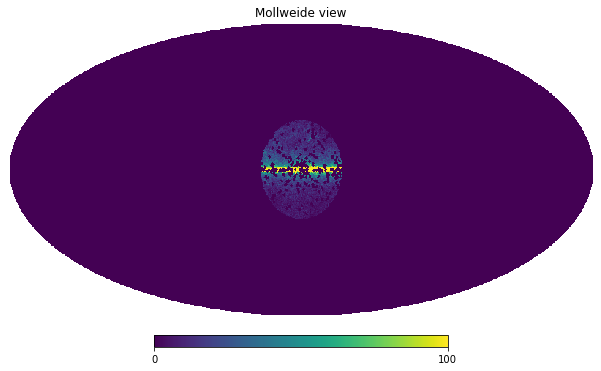

In [7]:
in_map = np.load("../../fermi-gce-gp/data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [9]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [10]:
in_map.shape

torch.Size([1, 16384, 1])

In [11]:
in_map = in_map.to(device)

In [12]:
sg(in_map).shape

torch.Size([1, 512])

In [13]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")

In [14]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [15]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [16]:
from simulations.wrapper import simulator

In [17]:
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [18]:
theta = [3, 10., 1.9, -10., 20., 0.1]
simulator(theta, masks_list[0], temp_gce, pc_inst.psf_r_func)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
from tqdm import *

In [20]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.5, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([3.0, 20.0, 1.9, 1.9, 50.0, 4.99]))

In [26]:
number_presimulated = 10

theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func) for theta in tqdm(theta_presimulated)]



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:02,  4.48it/s]

 20%|██        | 2/10 [00:00<00:01,  5.05it/s]

 30%|███       | 3/10 [00:00<00:01,  4.95it/s]

 40%|████      | 4/10 [00:00<00:01,  5.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.90it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.65it/s]

100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


In [21]:
theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train.npy")[:100000]
x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train.npy")[:100000]

In [22]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [23]:
theta_presimulated[:, 0] = torch.log10(theta_presimulated[:, 0])

In [24]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

In [25]:
simulator_model = lambda theta: simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func)

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = inference.prepare_for_sbi(simulator_model, prior)

# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = inference.SNPE(simulator_wrapper, prior,
                           density_estimator=neural_classifier, 
                           show_progress_bars=True, show_round_summary=True, 
                           logging_level='INFO',
                             sample_with_mcmc=False,
                             mcmc_method="slice_np",
                             device=device)

../simulations/wrapper.py:11: RuntimeWarning: overflow encountered in power
  theta[0] = 10 ** theta[0]
/home/sm8383/anaconda3/lib/python3.8/site-packages/sbi-0.13.2-py3.8.egg/sbi/utils/torchutils.py:26: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [26]:
inference_inst.provide_presimulated(theta_presimulated, x_presimulated[:, 0, :])

In [ ]:
# run the inference procedure on one round and 10000 simulated data points
posterior = inference_inst(num_simulations=0, training_batch_size=64, max_num_epochs=100)

In [ ]:
torch.save(posterior, "/Users/smsharma/Desktop/test.pt")

In [ ]:
posterior = torch.load("/Users/smsharma/Desktop/test.pt")

In [66]:
np.argmax(theta_presimulated[:, 0])

tensor(87332)

In [67]:
idx = 87332

true_parameter = theta_presimulated[idx]
x_observed = x_presimulated[idx]

true_parameter

tensor([ 3.0000, 17.9324,  1.7944, -2.4927, 36.3331,  4.7834])

In [68]:
# generate posterior samples
# true_parameter = torch.tensor([2.5, 10., 1.9, -10., 20., 0.1])
# x_observed = simulator_model(true_parameter)

# true_parameter = theta_presimulated[2]
# x_observed = x_presimulated[2]

samples = posterior.set_default_x(x_observed).sample((300,), sample_with_mcmc=True)

Generating samples: 100%|██████████| 300/300 [25:49<00:00,  5.16s/it]


In [59]:
import corner

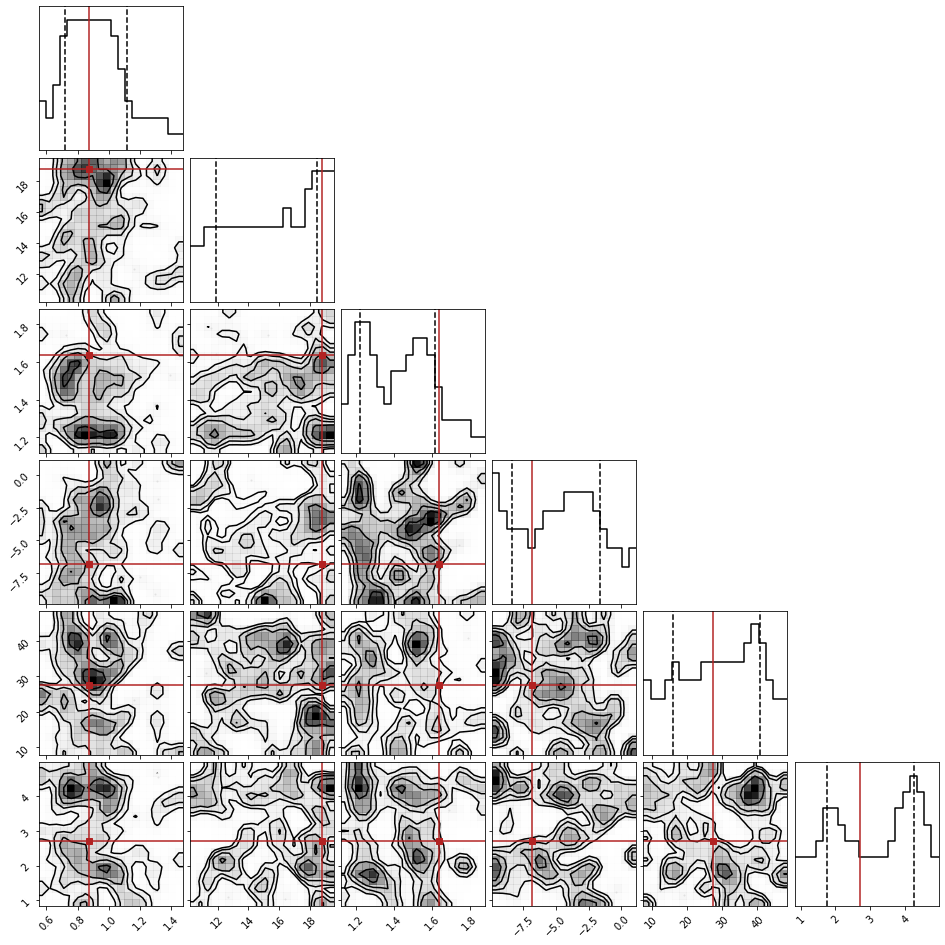

In [54]:
corner.corner(samples, truths=true_parameter, smooth=1, smooth1d=1, truth_color='firebrick', quantiles=(0.16, 0.84));